# Solution Part 2 - Pixel, Lane and Output

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import os
import glob
import warnings
import pickle
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import ipywidgets as widgets
from moviepy.editor import VideoFileClip

In [2]:
# setting

DOCS_FOLDER = "./docs"
os.makedirs(DOCS_FOLDER, exist_ok=True)
OUTPUT_FOLDER_PIPELINE = "./output_images"
os.makedirs(OUTPUT_FOLDER_PIPELINE, exist_ok=True)
FIG_SIZE = (16, 8)
GLOB_CALIBRATION_IMAGES = "./camera_cal/*.jpg"
GLOB_TEST_IMAGES = "./test_images/*.jpg"

## Load data and utility functions from part 1

In [3]:
# load previous data

data_store__part_1 = pickle.load(open("data_store__part_1.pkl", "rb"))
locals().update(data_store__part_1)

In [4]:
data_store__part_1

{'MTX': array([[1.15662906e+03, 0.00000000e+00, 6.69041437e+02],
        [0.00000000e+00, 1.15169194e+03, 3.88137239e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'DIST': array([[-0.2315715 , -0.12000538, -0.00118338,  0.00023305,  0.15641572]]),
 'SRC_POINTS': [(205, 720), (581, 460), (701, 460), (1107, 720)],
 'DST_POINTS': [(290, 720), (290, 0), (990, 0), (990, 720)],
 'M': array([[-5.53999756e-01, -1.49147693e+00,  9.80411543e+02],
        [-6.16188822e-16, -1.97686594e+00,  9.09358334e+02],
        [-5.86605631e-19, -2.38037258e-03,  1.00000000e+00]]),
 'MINV': array([[ 1.71428571e-01, -7.69065657e-01,  5.31285714e+02],
        [-5.74175948e-17, -5.05851195e-01,  4.60000000e+02],
        [-0.00000000e+00, -1.20411431e-03,  1.00000000e+00]]),
 'XM_PER_PIX': 0.005285714285714286,
 'YM_PER_PIX': 0.0254}

In [5]:
# Utility

def load_img(path_img):
    img = mpimg.imread(path_img)
    return img

def convert_gray(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray

def undistort_img(img):
    return cv2.undistort(img, MTX, DIST)

def load_undistort_img(path_img):
    img = load_img(path_img)
    return undistort_img(img)

def warp_image(img):
    img_size = img.shape[1], img.shape[0]
    return cv2.warpPerspective(img, M, img_size)

def unwarp_image(img):
    img_size = img.shape[1], img.shape[0]
    return cv2.warpPerspective(img, MINV, img_size)

def draw_polylines(img, pts, is_closed=True, color=[255, 0, 0], thickness=2):
    pts = np.asarray(pts).reshape(-1, 1, 2)
    return cv2.polylines(img, [pts], is_closed, color, thickness)

# Gradient & Color Thresholds

* Use color transforms, gradients, etc., to create a thresholded binary image.


## Motivation

Naturally one of the main components is to detect the lane pixels in the image. For this we were taught several gradient and color thresholding techniques in the course. 

For clear visible lane markers one can readily detect them by approriate edge detction techniques, all relying on the gradient or nearby pixel variations:

- Derivative in x or y direction: Here one computes the pixel variation along x- or y- direction to detect vertical or horizontal edges. The gradient in a given direction can be computed with ``cv2.Sobel(gray, order)`` with ``order`` being a tuple specifiying the direction, e.g., ``order=(1, 0)`` for the x direction.
- Gradient magnitude: The length of overall gradient can be computed directly from the derivatives in x- and y- direction, and is used to detect clear edges in an arbitrary direction.
- Gradient direction: Usually lane lines and markers are somewhat pointing into a vertical fanned direction, hence its edges are also somewhat directionally constrained. Such edges can be filtered out knowing the gradient direction or angle that can be readily computed from its x and y component via ``np.arctan2``.

Via the gradient thresholds one gets problems if the lane lines or markers are in the shadow or on a not high contrast road surface. Additionally those are methods are usually applied on a grayscaled version of the image. In addition for color images one can also select a different color space. The HLS, which stands for hue, lightness and saturation was explained to be favorable option here.

- Color threshold transform: Convert the color image into the HLS space, picks its saturation components and threshold lines there.

Of course the above methods can be combined in an arbitrary fashion and each components requires parameter tuning again. For this I was following closely the examples given in course and was combining:
1. Strong derivate in x and derivate in y
2. Direction and length
3. Color threshold

For parameter tuning I made myself again a small interactive widget that allowed me to scan for good candidates.

In [6]:
# Binary masking functions from the course

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """Absolute gradient threshold along x or y direction."""
    if orient not in ['x', 'y']:
        raise ValueError("orient must be either 'x' or 'y'")
    gray = convert_gray(img)
    order = (1, 0) if orient == 'x' else (0, 1)
    grad = cv2.Sobel(gray, cv2.CV_64F, *order, ksize=sobel_kernel)
    abs_grad = np.abs(grad)
    scaled_grad = np.uint8(255.0 * abs_grad / np.max(abs_grad))
    mask = (thresh[0] <= scaled_grad) & (scaled_grad < thresh[1])
    binary_output = np.zeros_like(scaled_grad)
    binary_output[mask] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """Threshold on gradient magnitude"""
    gray = convert_gray(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_mag = np.uint8(255.0 * mag / np.max(mag))
    mask = (thresh[0] <= scaled_mag) & (scaled_mag <= thresh[1])
    binary_output = np.zeros_like(scaled_mag)
    binary_output[mask] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Filter by gradient direction"""
    gray = convert_gray(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # note: arctan2 assumes input ordering y, x
    direct = np.arctan2(abs_sobely, abs_sobelx)
    mask = (thresh[0] <= direct) & (direct <= thresh[1])
    binary_output = np.zeros_like(direct)
    binary_output[mask] = 1
    return binary_output


def s_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:, :, 2]
    mask = (thresh[0] < S) & (S <= thresh[1])
    binary_output = np.zeros_like(S)
    binary_output[mask] = 1
    return binary_output

In [7]:
# Utility to plot a collection of images

def show_images(d_images, cols=2):
    """Displays all images in the dictionary."""
    rows = -(-len(d_images) // cols)
    fig = plt.figure(figsize=(16, 4 * rows))
    for i, k in enumerate(d_images, start=1):
        plt.subplot(rows, cols, i)
        img = d_images[k]
        cm = "gray" if img.ndim == 2 else None
        plt.imshow(img, cmap=cm)
        plt.axis('off')
        plt.title(k)
    plt.tight_layout()
    return fig

In [8]:
# make a config class utilized in the threshold_img function

Config = namedtuple("Config", (
    " thresh_abs kernel_abs "
    " thresh_mag kernel_mag thresh_dir kernel_dir "
    " thresh_s "
))


def threshold_img(img, cfg: Config, return_collection=False):
    gradx_binary = abs_sobel_thresh(img, 'x', cfg.kernel_abs, cfg.thresh_abs)
    grady_binary = abs_sobel_thresh(img, 'y', cfg.kernel_abs, cfg.thresh_abs)
    mag_binary = mag_thresh(img, cfg.kernel_mag, cfg.thresh_mag)
    dir_binary = dir_threshold(img, cfg.kernel_dir, cfg.thresh_dir)
    s_binary = s_select(img, cfg.thresh_s)
    combined = np.zeros_like(s_binary)
    cond__x_y = ((gradx_binary == 1) & (grady_binary == 1)) 
    cond__mag_dir = ((mag_binary == 1) & (dir_binary == 1))
    cond__s = (s_binary == 1)
    combined[cond__x_y | cond__mag_dir | cond__s] = 1
    res = combined
    if return_collection:
        res =  {
            'combined': combined,
            'x-y': cond__x_y,
            'mag-dir': cond__mag_dir,
            's': cond__s
        }
    return res

In [9]:
# solution are taken to be the new default setting after optimization, so that notebook can savely rerun

CFG = None


@widgets.interact(
    path_img=widgets.Dropdown(options=glob.glob(GLOB_TEST_IMAGES)),
    thresh_abs=widgets.IntRangeSlider(value=[20, 255], min=0, max=255, step=5, continuous_update=False),
    kernel_abs=widgets.IntSlider(value=3, min=1, max=15, step=2, continuous_update=False),
    thresh_mag=widgets.IntRangeSlider(value=[55, 175], min=0, max=255, step=5, continuous_update=False),
    kernel_mag=widgets.IntSlider(value=3, min=1, max=15, step=2, continuous_update=False),
    thresh_dir=widgets.FloatRangeSlider(value=[0.7, 1.3], min=0, max=1.6, step=0.1, continuous_update=False),
    kernel_dir=widgets.IntSlider(value=9, min=1, max=15, step=2, continuous_update=False),
    thresh_s=widgets.IntRangeSlider(value=[175, 255], min=0, max=255, step=5, continuous_update=False)
)
def tuning_threshold_img(path_img, **kwargs):
    global CFG
    CFG = Config(**{k: v for k, v in kwargs.items() if k in Config._fields})
    img = load_undistort_img(path_img)
    gallery = {"original": img}
    res = threshold_img(img, CFG, return_collection=True)
    gallery.update(res)
    gallery["wrap"] = warp_image(gallery["combined"])
    show_images(gallery, 2)
    plt.tight_layout()

interactive(children=(Dropdown(description='path_img', options=('./test_images\\straight_lines1.jpg', './test_…

In [10]:
CFG

Config(thresh_abs=(20, 255), kernel_abs=3, thresh_mag=(55, 175), kernel_mag=3, thresh_dir=(0.7, 1.3), kernel_dir=9, thresh_s=(175, 255))

In [11]:
@widgets.interact
def show_threshold(path_img=glob.glob(GLOB_TEST_IMAGES)):
    img = load_undistort_img(path_img)
    binary_threshold = threshold_img(img, CFG)
    warp_binary_threshold = warp_image(binary_threshold)
    show_images({
        "Original": img,
        "Threshold": binary_threshold, 
        "Warped": warp_image(img),
        "Warped Threshold": warp_image(binary_threshold),
    }, 4)

interactive(children=(Dropdown(description='path_img', options=('./test_images\\straight_lines1.jpg', './test_…

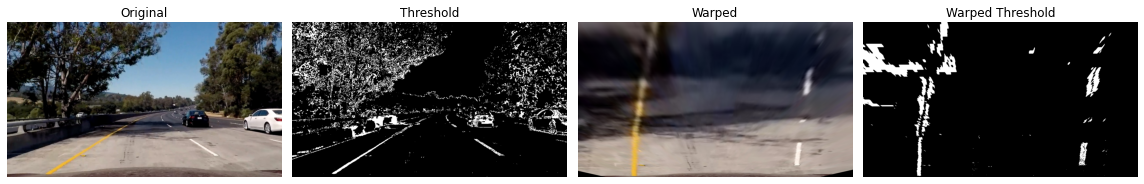

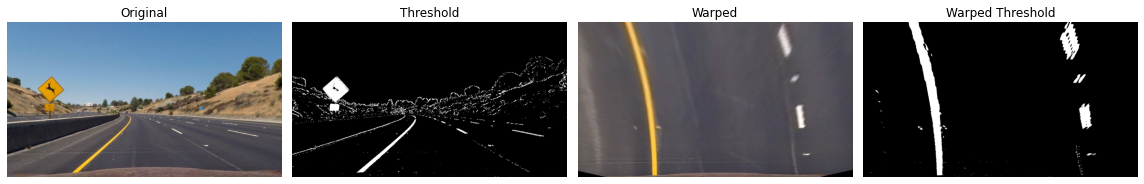

In [12]:
show_threshold("./test_images/test5.jpg")
plt.savefig(os.path.join(DOCS_FOLDER, "threshold_test5.jpg"))
plt.show()
show_threshold("./test_images/test2.jpg")
plt.savefig(os.path.join(DOCS_FOLDER, "threshold_test2.jpg"))
plt.show()

# Lane Pixels & Fit

Detect lane pixels and fit to find the lane boundary.


## Motivation
After warping the thresholded image we need to detect lane pixels and fit a quadratic polynomial to determine the lane curvature and relative lane position in the next step.

Detecting lane pixels from scratch is done along the following line, and a direct implementation has been given in the course material. I only did some cosmetic code modification and annoted the imporant steps in the core function ``find_lane_pixels``:

- First we determine the left and right bottom lane x positions using the histogram peaks in the lower part of the image, ``step a``. 
- Using these positions as starting points we repeatedly look for pixels in a small window centered at these current positions, ``step b``. If we find sufficiently many new pixels in a given window, we take its mean x-position as the new center for the next sligind window, ``step c``. 
- All pixels detected in these windows are lane pixels.


Note if we have prior information about the lane positions, for instance via the fit of a previous frame, we could utilize this information rather than trying to detect lane pixels from scratch. However, I did not pursue this direction because of timing reasons.

Once having determined the lane pixels we can directly fit a quadratic polynomial x=x(y), which can be carried out using ``np.polyfit`` function.

In [13]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    """Fit quadratic polynomial to left and right pixels
    and return its parameters and predictions."""
    # fit parameter
    left_fit = np.polyfit(lefty, leftx, deg=2)
    right_fit = np.polyfit(righty, rightx, deg=2)
    # create predictions
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return (left_fit, right_fit), (left_fitx, right_fitx, ploty)


def add_predictions(out_img, left_fitx, right_fitx, ploty):
    """Adds predictions to image"""
    for fitx in [left_fitx, right_fitx]:
        out_img = cv2.polylines(out_img, [np.asarray([fitx, ploty]).T.astype(np.int32)], False, [255, 255, 0], 4)
    return out_img


def find_lane_pixels(binary_warped, return_img=True):
    """Find lane pixels using sliding window approach."""
    
    # step a
    # find bottom lane points via histogram peaks
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2 :, :], axis=0)
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # hyperparameter
    nwindows = 9  # sliding window
    margin = 100  # margin
    minpix = 50   # minimum number of pixels for recenter

    # init
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    if return_img:
        out_img = 255 * np.dstack((binary_warped, binary_warped, binary_warped))

    # loop over windows
    for window in range(nwindows):
        # window boundaries
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw window
        if return_img:
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 

        # step b
        # identify pixels falling in current window
        good_left_inds = [
            i for i, (x, y) in enumerate(zip(nonzerox, nonzeroy))
            if (win_xleft_low <= x < win_xleft_high) and (win_y_low <= y < win_y_high)
        ]
        good_right_inds = [
            i for i, (x, y) in enumerate(zip(nonzerox, nonzeroy))
            if (win_xright_low <= x < win_xright_high) and (win_y_low <= y <= win_y_high)
        ]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # step c
        # recenter if we found sufficiently many
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # prepare lane pixels
    left_lane_inds = np.concatenate(left_lane_inds).astype(np.int)
    right_lane_inds = np.concatenate(right_lane_inds).astype(np.int)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    result = {
        'lane_pixels': (leftx, lefty, rightx, righty)
    }

    # fit
    (left_fit, right_fit), (left_fitx, right_fitx, ploty) = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    result["fit_parameter"] = (left_fit, right_fit)
    result["fit_predictions"] = (left_fitx, right_fitx, ploty)
    
    if return_img:
        # color lane pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        out_img = add_predictions(out_img, left_fitx, right_fitx, ploty)
    
    res = result
    if return_img:
        res = result, out_img
    return res

In [14]:
@widgets.interact
def show_lane_fit(img_path=glob.glob(GLOB_TEST_IMAGES)):
    img = load_undistort_img(img_path)
    img_thresh = threshold_img(img, CFG)
    warp_thresh = warp_image(img_thresh)
    __, img_lane = find_lane_pixels(warp_thresh)
    show_images({
        "Original": img,
        "Threshold": img_thresh,
        "Warped Treshold": warp_thresh,
        "Lane": img_lane,
    }, 4)

interactive(children=(Dropdown(description='img_path', options=('./test_images\\straight_lines1.jpg', './test_…

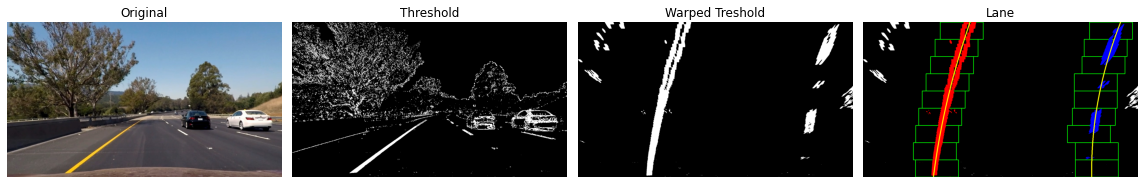

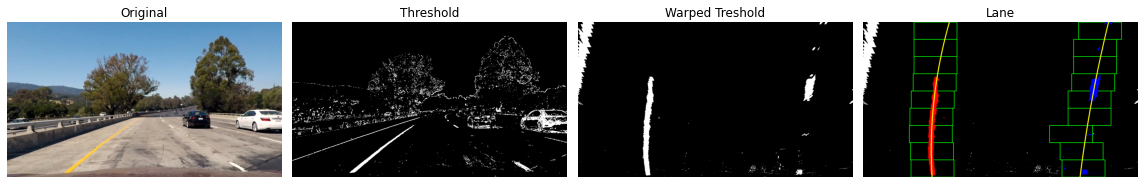

In [15]:
show_lane_fit("./test_images/test6.jpg")
plt.savefig(os.path.join(DOCS_FOLDER, "lane_fit_test6.jpg"))
plt.show()
show_lane_fit("./test_images/test1.jpg")
plt.savefig(os.path.join(DOCS_FOLDER, "lane_fit_test1.jpg"))
plt.show()

# Compute Measures

* Determine the curvature of the lane and vehicle position with respect to center.

## Motivation

Finally, we compute curvature and vehicle positions, both of which can be computed from the fits. Curvature of each lane is given by an analytic formula involving the fit coefficients and the according y-position of interest; in our case the bottom of the image because this closest to the vehicle. For a fit of ``x(y) = A*y**2 + B*y + C`` this is given by ``C(y) = (1 + (2 * A * y_eval + B)**2 )**1.5 / abs(2 * A)``.

The relative vehicle position can be computed from the difference between the midpoint of left and right lane spots at the bottom of the warped image and the assumed car center, in our case the horizontal center.

Both pixel values need to be converted to real units by the pixel-to-meter conversions, that we determined during the perspective transformation. 

I had several difficulties in computing the curvature and I was constantly getting too high values. I used the fit paramter scaling trick in the course, but always forgot to scale the y-position of interest. In the end, the following post largely resolved these difficulties: https://knowledge.udacity.com/questions/18801

In [16]:
def compute_curvature(fit, y_eval):
    A, B, C = fit
    A = XM_PER_PIX / YM_PER_PIX**2 * A
    B = XM_PER_PIX / YM_PER_PIX * B
    y_eval = y_eval * YM_PER_PIX
    curverad = (1 + (2 * A * y_eval + B)**2 )**1.5 / np.abs(2 * A)
    return curverad

def compute_vehicle_position(left_x, right_x, center):
    mid = (left_x + right_x) / 2
    pos = (mid - center)
    pos = pos * XM_PER_PIX
    return pos

def compute_measures(left_fit, right_fit, img_shape):
    y_eval = img_shape[0] - 1
    left_curve = compute_curvature(left_fit, y_eval)
    right_curve = compute_curvature(right_fit, y_eval)
    avg_curve = (left_curve + right_curve) / 2
    bottom_left_x = left_fit[0] * y_eval ** 2 + left_fit[1] * y_eval + left_fit[2]
    bottom_left_y = right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[2]
    center = (img_shape[1] - 1) / 2
    pos = compute_vehicle_position(bottom_left_x, bottom_left_y, center)
    return avg_curve, pos

#### Just checking curvature computation

In [17]:
# dev 
# example checking both curvature computations

img = load_undistort_img("./test_images/test2.jpg")
img_thresh = threshold_img(img, CFG)
warp_thresh = warp_image(img_thresh)
res, img_lane = find_lane_pixels(warp_thresh)
left_fit, right_fit = res["fit_parameter"]
print(compute_measures(left_fit, right_fit, img_lane.shape))
xs, ys = res["lane_pixels"][:2]
xs = np.array(xs).astype('float')
ys = np.array(ys).astype('float')

(263.3851642145853, 0.32272440883567804)


In [18]:
# Option 1 - Scale data points before

scale_xs = XM_PER_PIX * xs
scale_ys = YM_PER_PIX * ys
A, B, C = np.polyfit(scale_ys, scale_xs, deg=2)
y_eval = 719 * YM_PER_PIX
(1 + (2 * A * y_eval + B)**2 )**1.5 / np.abs(2 * A)

237.8807563996757

In [19]:
# Option 2 - Scale fit parameters

A, B, C = np.polyfit(ys, xs, deg=2)
A = XM_PER_PIX / YM_PER_PIX**2 * A
B = XM_PER_PIX / YM_PER_PIX * B
y_eval = 719 * YM_PER_PIX
(1 + (2 * A * y_eval + B)**2 )**1.5 / np.abs(2 * A)

237.8807563996766

# Finalizing output

* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Motivation
Of course we want to warp the detected lane back to the original, distortion corrected image, and add the computed measures. For this a utility function has been given in the tips and tricks part of the the project description.

In [20]:
def unwarp_lane(undist, warped, left_fit, right_fit, left_fitx, right_fitx, ploty):
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = unwarp_image(color_warp)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # compute measures and add them to image
    curverad, position = compute_measures(left_fit, right_fit, result.shape)
    text =  f'Curve: {round(curverad, 2)}m, Position: {round(position, 2)}m'
    result = cv2.putText(result, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return result

## Finalizing outputs
Let us wrap everything into a single function.

In [21]:
# Everything into a single function

def pipeline(img, return_collection=False):
    img_thresh = threshold_img(img, CFG)
    warp_thresh = warp_image(img_thresh)
    res, img_lane = find_lane_pixels(warp_thresh)
    left_fit, right_fit = res["fit_parameter"]
    left_fitx, right_fitx, ploty = res["fit_predictions"]
    result = unwarp_lane(img, warp_thresh, left_fit, right_fit, left_fitx, right_fitx, ploty)
    rv = result
    if return_collection:
        rv = {
            "Undistored": img,
            "Result": result,
            "Threshold": img_thresh,
            "Lane": img_lane,
        }
    return rv

In [22]:
@widgets.interact
def show_pipeline(path_img=glob.glob(GLOB_TEST_IMAGES)):
    img = load_undistort_img(path_img)
    res = pipeline(img, return_collection=True)
    show_images(res)
    plt.tight_layout()

interactive(children=(Dropdown(description='path_img', options=('./test_images\\straight_lines1.jpg', './test_…

### Create pipeline images

In [23]:
for fname in os.listdir("./test_images/"):
    print(fname)
    path_img = os.path.join("./test_images/", fname)
    path_out = os.path.join(OUTPUT_FOLDER_PIPELINE, f"pipeline__{fname}")
    show_pipeline(path_img)
    plt.savefig(path_out)
    plt.close()

straight_lines1.jpg
straight_lines2.jpg
test1.jpg
test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg


### Create video

In [24]:
video_output = 'project_video_out.mp4'
video_input = VideoFileClip("project_video.mp4")
processed_video = video_input.fl_image(pipeline)

%time processed_video.write_videofile(video_output, audio=False)

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4
Wall time: 12min 21s
